# Hauling Opeartion Simulation
This Notebook models and simulates the hauling operation using the OpenCLSim package, incorporating:

- Hauling Cycle: Drive empty-load-drive full-unload
- Queuing at source and destination
- One type of material (Waste) 
- Importing the number of trucks, truck-shovel allocations, and hauling scenarios from designated files

In [1]:
import networkx as nx  
import shapely.geometry
import pyproj


import datetime as dt
import time
import simpy
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
import opentnsim

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import folium

**Importing Data Files**

In [2]:
# Read destinations.csv, sources.csv, and ancillary.csv
# hauling_df = pd.read_csv('Destinations.csv')


**Creating required list for trucks**

In [13]:
import pandas as pd

# Read the CSV file
file_path = 'HaulageOperation_TruckDetails.csv'
df = pd.read_csv(file_path)

# Create an empty list to store information about each truck
truck_list = []

# Initialize a counter for overall truck numbering
overall_truck_counter = 1

# Iterate through rows and repeat based on the number of trucks
for index, row in df.iterrows():
    # Convert 'Number of trucks' to integer
    num_trucks = int(row['Number of Trucks'])
    
    for truck_num in range(num_trucks):
        # Create a dictionary for each truck
        truck_info = {
            'ID': row['ID'],
            'Name of the trucks': f'truck{overall_truck_counter}',
            'Type': row['Type'],
            'Payload (Ton)': row['Payload (Ton)'],
            'Minimum Speed (Mile/Hour)': row['Minimum Speed (Mile/Hour)'],
            'Maximum Speed (Mile/Hour)': row['Maximum Speed (Mile/Hour)'],
            'Unloading Time (Minute)': row['Unloading Time (Minute)'],
            'Param 1': row['Param 1'],
            'Param 2': row['Param 2']
        }
        # Increment the overall truck counter
        overall_truck_counter += 1
        
        # Append the truck information to the list
        truck_list.append(truck_info)

# Create a new data frame from the list
df_result = pd.DataFrame(truck_list)

# Display the resulting data frame
print("Resulting Data Frame:")
print(df_result)

# Calculate the total number of trucks as an integer
total_trucks = int(df['Number of Trucks'].sum())
print("\nTotal Number of Trucks:", total_trucks)


Resulting Data Frame:
     ID Name of the trucks    Type  Payload (Ton)  Minimum Speed (Mile/Hour)  \
0   1.0             truck1  HD-785          100.0                        5.0   
1   1.0             truck2  HD-785          100.0                        5.0   
2   1.0             truck3  HD-785          100.0                        5.0   
3   1.0             truck4  HD-785          100.0                        5.0   
4   1.0             truck5  HD-785          100.0                        5.0   
5   1.0             truck6  HD-785          100.0                        5.0   
6   1.0             truck7  HD-785          100.0                        5.0   
7   1.0             truck8  HD-785          100.0                        5.0   
8   1.0             truck9  HD-785          100.0                        5.0   
9   1.0            truck10  HD-785          100.0                        5.0   
10  2.0            truck11  HD-325          100.0                        5.0   
11  2.0           

**Defining object classes**

In [14]:
# create a Site object based on desired mixin classes
Site = type('Site',
            (core.Identifiable,
             core.Log,
             core.Locatable,
             core.HasMultiContainer,
             core.HasResource,), {})

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.MultiContainerDependentMovable,
        core.HasResource,
        core.Processor,
        core.Identifiable,
        core.Log,
        opentnsim.core.ExtraMetadata
    ),
    {},
)

**Defining the locations**

In [33]:
def run(total_trucks, total_ore, total_waste):
    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    # create site objects
    # prepare data for stockpile locations
    location_stockpile = shapely.geometry.Point(3.637610458072877, 52.10701582514347)
    data_stockpile = {"env": my_env,
                    "name": "stockpile",
                    "geometry": location_stockpile,
                    "initials": [
                        {"id": "ore", "level": 0, "capacity": total_ore},
                        {"id": "waste", "level": 0, "capacity": 0},
                        ],
                    "nr_resources": 1,
                    }
    stockpile = Site(**data_stockpile)

    # prepare input data for source
    location_source = shapely.geometry.Point(4.062705498083785,51.95909715255291)
    data_source = {"env": my_env,
                "name": "source",
                "geometry": location_source,
                    "initials": [
                        {"id": "ore", "level": total_ore, "capacity": total_ore},
                        {"id": "waste", "level": total_waste, "capacity": total_waste},
                        ],
                "nr_resources": 1
                }
    source = Site(**data_source)
    
    # prepare input data for dump
    location_dump = shapely.geometry.Point(4.1795229742823,52.11590591837503)
    data_dump = {"env": my_env,
                "name": "dump",
                "geometry": location_dump,
                    "initials": [
                        {"id": "ore", "level": 0, "capacity": 0},
                        {"id": "waste", "level": 0, "capacity": total_waste},
                        ],
                }
    dump = Site(**data_dump)

    # create truck objects
    trucks = {}

    for i in range(1, total_trucks+1):
       trucks[f"truck{i}"] = TransportProcessingResource (
            env = my_env,
            name = f"truck{i}",
            geometry = location_dump,
            initials = [
                {"id": "ore", "level": 0, "capacity": 0},
                {"id": "waste", "level": 0, "capacity": 25},
                ],
            loading_rate = 1,
            undloading_rate = 2,
            compute_v = lambda x: 10 + 2 * x,
                )


 #Create activity objects
    activities_d_truck = {}

    for i in range (1, total_trucks+1):
        requested_resources = {}
        
        d_subprocesses = [
                model.MoveActivity(
                            env=my_env,
                            name=f"driving_empty:"+trucks[f"truck{i}"].name,
                            registry=registry,
                            mover=trucks[f"truck{i}"],
                            destination=source,
                            duration=20,
                    ),
                model.ShiftAmountActivity(
                            env=my_env,
                            name=f"loading:"+trucks[f"truck{i}"].name,
                            registry=registry,
                            processor=trucks[f"truck{i}"],
                            origin=source,
                            destination=trucks[f"truck{i}"],
                            amount=20,
                            duration=50,
                            id_="waste",
                            requested_resources=requested_resources,
                    ),
                model.MoveActivity(
                            env=my_env,
                            name=f"driving_full:"+trucks[f"truck{i}"].name,
                            registry=registry,
                            mover=trucks[f"truck{i}"],
                            destination=dump,
                            duration=15,
                    ),
                model.ShiftAmountActivity(
                            env=my_env,
                            name=f"unloading:"+trucks[f"truck{i}"].name,
                            registry=registry,
                            processor=trucks[f"truck{i}"],
                            origin=trucks[f"truck{i}"],
                            destination=dump,
                            amount=20,
                            duration= random.uniform(4, 8),
                            id_="waste",
                            requested_resources=requested_resources,
                    )
            ]
        activities_d_truck[f"activities_d_truck{i}"] = model.WhileActivity(
            env = my_env,
            name = f"while_sequential_activity_d_truck{i}",
            registry = registry,
            sub_processes= [model.SequentialActivity(
                env = my_env,
                name = f"sequential_activity_d_truck{i}",
                registry = registry,
                sub_processes = d_subprocesses
            )],
            condition_event = [{"type": "container",
                                "concept": dump,
                                "state": "full",
                                "id_": "default_reservations"}
                                ]
        )
    
    model.register_processes([*activities_d_truck.values()])
    my_env.run()

    return {
        "trucks": trucks,                                                                                                         
        "activities_d_truck": activities_d_truck,
        "stockpile": stockpile,
        "source": source,
        "dump": dump,
    }

In [40]:
res = run(3,500,500)
trucks = res['trucks']
activities_d_truck = res['activities_d_truck']
stockpile = res['stockpile']
source = res['source']
dump = res['dump']

In [41]:
fig = plot.get_gantt_chart([*trucks.values()], id_map=[*activities_d_truck.values()])

In [36]:
display(plot.get_log_dataframe(source,id_map=[*activities_d_truck.values()]))

,Activity,Timestamp,ActivityState,container level,geometry
0,loading:truck1,1970-01-01 00:00:20,START,"{'ore': 500, 'waste': 500}",POINT (4.062705498083785 51.95909715255291)
1,loading:truck1,1970-01-01 00:01:10,STOP,"{'ore': 500, 'waste': 480}",POINT (4.062705498083785 51.95909715255291)
2,loading:truck2,1970-01-01 00:01:10,START,"{'ore': 500, 'waste': 480}",POINT (4.062705498083785 51.95909715255291)
3,loading:truck2,1970-01-01 00:02:00,STOP,"{'ore': 500, 'waste': 460}",POINT (4.062705498083785 51.95909715255291)
4,loading:truck3,1970-01-01 00:02:00,START,"{'ore': 500, 'waste': 460}",POINT (4.062705498083785 51.95909715255291)
5,loading:truck3,1970-01-01 00:02:50,STOP,"{'ore': 500, 'waste': 440}",POINT (4.062705498083785 51.95909715255291)
6,loading:truck4,1970-01-01 00:02:50,START,"{'ore': 500, 'waste': 440}",POINT (4.062705498083785 51.95909715255291)
7,loading:truck4,1970-01-01 00:03:40,STOP,"{'ore': 500, 'waste': 420}",POINT (4.062705498083785 51.95909715255291)
8,loading:truck5,1970-01-01 00:03:40,START,"{'ore': 500, 'waste': 420}",POINT (4.062705498083785 51.95909715255291)
9,loading:truck5,1970-01-01 00:04:30,STOP,"{'ore': 500, 'waste': 400}",POINT (4.062705498083785 51.95909715255291)


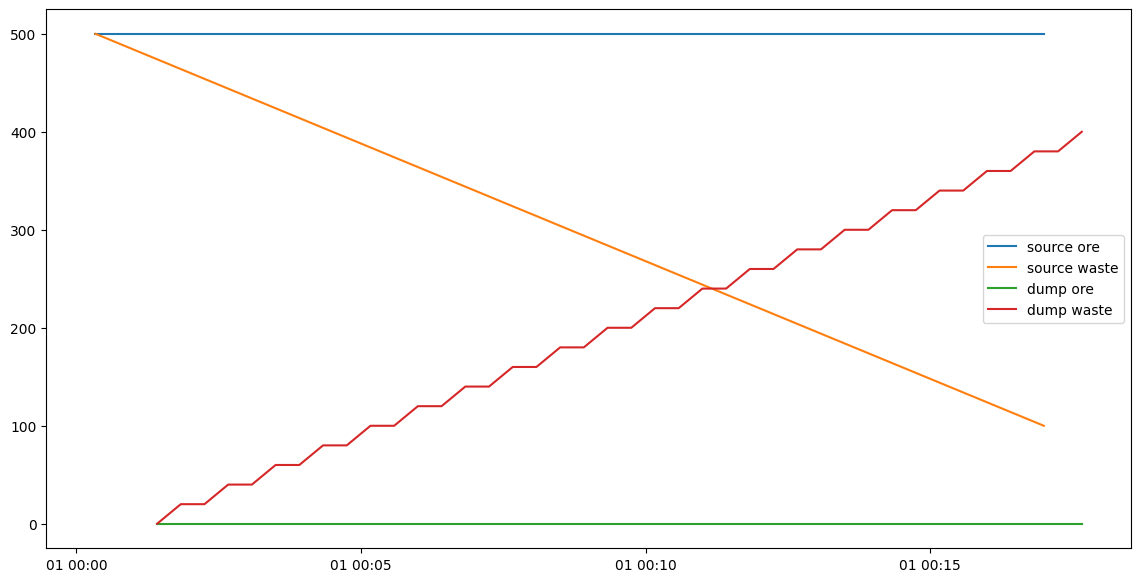

In [37]:
fig = plot.get_step_chart([source, dump])

In [42]:
import networkx as nx  
import shapely.geometry
import pyproj

import datetime as dt
import time
import simpy
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
import opentnsim

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [43]:

# Read the CSV file
file_path = 'HaulageOperation_TruckDetails.csv'
df = pd.read_csv(file_path)

# Create an empty list to store information about each truck
truck_list = []

# Initialize a counter for overall truck numbering
overall_truck_counter = 1

# Iterate through rows and repeat based on the number of trucks
for index, row in df.iterrows():
    # Convert 'Number of trucks' to integer
    num_trucks = int(row['Number of Trucks'])
    
    for truck_num in range(num_trucks):
        # Create a dictionary for each truck
        truck_info = {
            'ID': row['ID'],
            'Name of the trucks': f'truck{overall_truck_counter}',
            'Type': row['Type'],
            'Payload (Ton)': row['Payload (Ton)'],
            'Minimum Speed (Mile/Hour)': row['Minimum Speed (Mile/Hour)'],
            'Maximum Speed (Mile/Hour)': row['Maximum Speed (Mile/Hour)'],
            'Unloading Time (Minute)': row['Unloading Time (Minute)'],
            'Param 1': row['Param 1'],
            'Param 2': row['Param 2']
        }
        # Increment the overall truck counter
        overall_truck_counter += 1
        
        # Append the truck information to the list
        truck_list.append(truck_info)

# Create a new data frame from the list
df_result = pd.DataFrame(truck_list)

# Display the resulting data frame
print("Resulting Data Frame:")
print(df_result)

# Calculate the total number of trucks as an integer
total_trucks = int(df['Number of Trucks'].sum())

Resulting Data Frame:
     ID Name of the trucks    Type  Payload (Ton)  Minimum Speed (Mile/Hour)  \
0   1.0             truck1  HD-785          100.0                        5.0   
1   1.0             truck2  HD-785          100.0                        5.0   
2   1.0             truck3  HD-785          100.0                        5.0   
3   1.0             truck4  HD-785          100.0                        5.0   
4   1.0             truck5  HD-785          100.0                        5.0   
5   1.0             truck6  HD-785          100.0                        5.0   
6   1.0             truck7  HD-785          100.0                        5.0   
7   1.0             truck8  HD-785          100.0                        5.0   
8   1.0             truck9  HD-785          100.0                        5.0   
9   1.0            truck10  HD-785          100.0                        5.0   
10  2.0            truck11  HD-325          100.0                        5.0   
11  2.0           

In [44]:
# create a Site object based on desired mixin classes
Site = type('Site',
            (core.Identifiable,
             core.Log,
             core.Locatable,
             core.HasMultiContainer,
             core.HasResource,), {})

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.MultiContainerDependentMovable,
        core.HasResource,
        core.Processor,
        core.Identifiable,
        core.Log,
        opentnsim.core.ExtraMetadata
    ),
    {},
)

In [51]:
def run(total_trucks, total_waste):
    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    # prepare input data for source
    location_source = shapely.geometry.Point(4.062705498083785,51.95909715255291)
    data_source = {"env": my_env,
                "name": "source",
                "geometry": location_source,
                    "initials": [
                        {"id": "waste", "level": total_waste, "capacity": total_waste},
                        ],
                "nr_resources": 1
                }
    source = Site(**data_source)
    
    # prepare input data for dump
    location_dump = shapely.geometry.Point(4.1795229742823,52.11590591837503)
    data_dump = {"env": my_env,
                "name": "dump",
                "geometry": location_dump,
                    "initials": [
                        {"id": "ore", "level": 0, "capacity": 0},
                        {"id": "waste", "level": 0, "capacity": total_waste},
                        ],
                }
    dump = Site(**data_dump)

    # create truck objects
    trucks = {}

    for i in range(1, total_trucks + 1):
    # Extract information from the truck list
        truck_info = df_result[df_result['Name of the trucks'] == f'truck{i}'].iloc[0]

        # Extract unloading time distribution parameters
        mean_unloading_time = truck_info['Param 1']
        std_dev_unloading_time = truck_info['Param 2']
        # Generate random unloading time from the specified distribution
        unloading_rate = np.random.normal(loc=mean_unloading_time, scale=std_dev_unloading_time)
    
        # Create an instance of TransportProcessingResource
        trucks[f"truck{i}"] = TransportProcessingResource (
            env=my_env,
            name=f"truck{i}",
            geometry=location_dump,
            initials=[
                {"id": "waste", "level": 0, "capacity": truck_info['Payload (Ton)']},
            ],
            loading_rate=1,
            unloading_rate=unloading_rate,
            compute_v=lambda x: 10 + 2 * x,
        )

 #Create activity objects
    activities_d_truck = {}

    for i in range (1, total_trucks+1):
        requested_resources = {}
        
        d_subprocesses = [
                model.MoveActivity(
                            env=my_env,
                            name=f"driving_empty:"+trucks[f"truck{i}"].name,
                            registry=registry,
                            mover=trucks[f"truck{i}"],
                            destination=source,
                            duration=20,
                    ),
                model.ShiftAmountActivity(
                            env=my_env,
                            name=f"loading:"+trucks[f"truck{i}"].name,
                            registry=registry,
                            processor=trucks[f"truck{i}"],
                            origin=source,
                            destination=trucks[f"truck{i}"],
                            amount=20,
                            duration=50,
                            id_="waste",
                            requested_resources=requested_resources,
                    ),
                model.MoveActivity(
                            env=my_env,
                            name=f"driving_full:"+trucks[f"truck{i}"].name,
                            registry=registry,
                            mover=trucks[f"truck{i}"],
                            destination=dump,
                            duration=15,
                    ),
                model.ShiftAmountActivity(
                            env=my_env,
                            name=f"unloading:"+trucks[f"truck{i}"].name,
                            registry=registry,
                            processor=trucks[f"truck{i}"],
                            origin=trucks[f"truck{i}"],
                            destination=dump,
                            amount=20,
                            duration= 25,
                            id_="waste",
                            requested_resources=requested_resources,
                    )
            ]
        activities_d_truck[f"activities_d_truck{i}"] = model.WhileActivity(
            env = my_env,
            name = f"while_sequential_activity_d_truck{i}",
            registry = registry,
            sub_processes= [model.SequentialActivity(
                env = my_env,
                name = f"sequential_activity_d_truck{i}",
                registry = registry,
                sub_processes = d_subprocesses
            )],
            condition_event = [{"type": "container",
                                "concept": dump,
                                "state": "full",
                                "id_": "default_reservations"}
                                ]
        )
    
    model.register_processes([*activities_d_truck.values()])
    my_env.run()

    return {
        "trucks": trucks,                                                                                                         
        "activities_d_truck": activities_d_truck,
        "source": source,
        "dump": dump,
    }

In [52]:
res = run(3,500)
trucks = res['trucks']
activities_d_truck = res['activities_d_truck']
source = res['source']
dump = res['dump']

In [53]:
fig = plot.get_gantt_chart([*trucks.values()], id_map=[*activities_d_truck.values()])

In [62]:
import networkx as nx  
import shapely.geometry
import pyproj


import datetime as dt
import time
import simpy
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
import opentnsim

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import folium

In [63]:

def run(total_trucks, total_waste):
    # Read the CSV file
    file_path = 'HaulageOperation_TruckDetails.csv'
    df = pd.read_csv(file_path)

    # Create an empty list to store information about each truck
    truck_list = []

    # Initialize a counter for overall truck numbering
    overall_truck_counter = 1

    # Iterate through rows and repeat based on the number of trucks
    for index, row in df.iterrows():
        # Convert 'Number of trucks' to integer
        num_trucks = int(row['Number of Trucks'])

        for truck_num in range(num_trucks):
            # Create a dictionary for each truck
            truck_info = {
                'ID': row['ID'],
                'Name of the trucks': f'truck{overall_truck_counter}',
                'Type': row['Type'],
                'Payload (Ton)': row['Payload (Ton)'],
                'Minimum Speed (Mile/Hour)': row['Minimum Speed (Mile/Hour)'],
                'Maximum Speed (Mile/Hour)': row['Maximum Speed (Mile/Hour)'],
                'Unloading Time (Minute)': row['Unloading Time (Minute)'],
                'Param 1': row['Param 1'],
                'Param 2': row['Param 2']
            }
            # Increment the overall truck counter
            overall_truck_counter += 1

            # Append the truck information to the list
            truck_list.append(truck_info)

    # Create a new data frame from the list
    df_result = pd.DataFrame(truck_list)

    # Calculate the total number of trucks as an integer
    total_trucks = int(df['Number of Trucks'].sum())

    # create a Site object based on desired mixin classes
    Site = type('Site',
                (core.Identifiable,
                 core.Log,
                 core.Locatable,
                 core.HasMultiContainer,
                 core.HasResource,), {})

    # create a TransportProcessingResource object based on desired mixin classes
    TransportProcessingResource = type(
        "TransportProcessingResource",
        (
            core.MultiContainerDependentMovable,
            core.HasResource,
            core.Processor,
            core.Identifiable,
            core.Log,
            opentnsim.core.ExtraMetadata
        ),
        {},
    )
    
    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    # prepare input data for source
    location_source = shapely.geometry.Point(4.062705498083785, 51.95909715255291)
    data_source = {"env": my_env,
                   "name": "source",
                   "geometry": location_source,
                   "initials": [
                       {"id": "waste", "level": total_waste, "capacity": total_waste},
                   ],
                   "nr_resources": 1
                   }
    source = Site(**data_source)

    # prepare input data for dump
    location_dump = shapely.geometry.Point(4.1795229742823, 52.11590591837503)
    data_dump = {"env": my_env,
                 "name": "dump",
                 "geometry": location_dump,
                 "initials": [
                     {"id": "ore", "level": 0, "capacity": 0},
                     {"id": "waste", "level": 0, "capacity": total_waste},
                 ],
                 }
    dump = Site(**data_dump)

    # create truck objects
    trucks = {}

    for i in range(1, total_trucks + 1):
        # Extract information from the truck list
        truck_info = df_result[df_result['Name of the trucks'] == f'truck{i}'].iloc[0]

        # Extract unloading time distribution parameters
        mean_unloading_time = truck_info['Param 1']
        std_dev_unloading_time = truck_info['Param 2']
        # Generate random unloading time from the specified distribution
        unloading_rate = np.random.normal(loc=mean_unloading_time, scale=std_dev_unloading_time)

        # Create an instance of TransportProcessingResource
        trucks[f"truck{i}"] = TransportProcessingResource(
            env=my_env,
            name=f"truck{i}",
            geometry=location_dump,
            initials=[
                {"id": "waste", "level": 0, "capacity": truck_info['Payload (Ton)']},
            ],
            loading_rate=1,
            unloading_rate=unloading_rate,
            compute_v=lambda x: 10 + 2 * x,
        )

    # Create activity objects
    activities_d_truck = {}

    for i in range(1, total_trucks + 1):
        requested_resources = {}

        d_subprocesses = [
            model.MoveActivity(
                env=my_env,
                name=f"driving_empty:" + trucks[f"truck{i}"].name,
                registry=registry,
                mover=trucks[f"truck{i}"],
                destination=source,
                duration=20,
            ),
            model.ShiftAmountActivity(
                env=my_env,
                name=f"loading:" + trucks[f"truck{i}"].name,
                registry=registry,
                processor=trucks[f"truck{i}"],
                origin=source,
                destination=trucks[f"truck{i}"],
                amount=20,
                duration=50,
                id_="waste",
                requested_resources=requested_resources,
            ),
            model.MoveActivity(
                env=my_env,
                name=f"driving_full:" + trucks[f"truck{i}"].name,
                registry=registry,
                mover=trucks[f"truck{i}"],
                destination=dump,
                duration=15,
            ),
            model.ShiftAmountActivity(
                env=my_env,
                name=f"unloading:" + trucks[f"truck{i}"].name,
                registry=registry,
                processor=trucks[f"truck{i}"],
                origin=trucks[f"truck{i}"],
                destination=dump,
                amount=20,
                duration=25,
                id_="waste",
                requested_resources=requested_resources,
            )
        ]
        activities_d_truck[f"activities_d_truck{i}"] = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_d_truck{i}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential_activity_d_truck{i}",
                registry=registry,
                sub_processes=d_subprocesses
            )],
            condition_event=[{"type": "container",
                              "concept": dump,
                              "state": "full",
                              "id_": "default_reservations"}
                             ]
        )

    model.register_processes([*activities_d_truck.values()])
    my_env.run()

    return {
        "trucks": trucks,
        "activities_d_truck": activities_d_truck,
        "source": source,
        "dump": dump,
    }

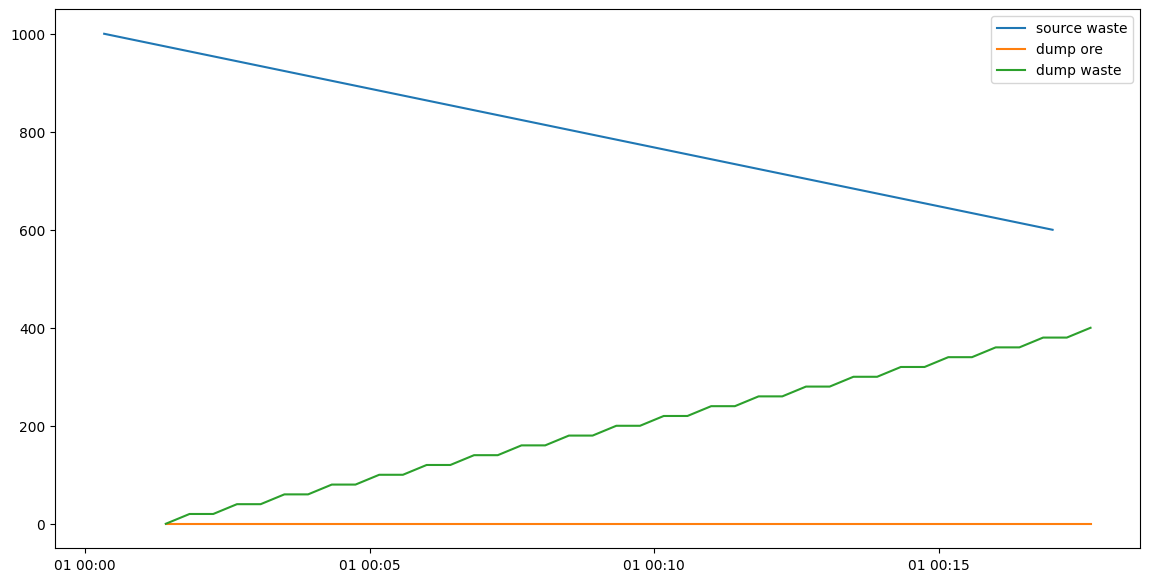

In [67]:
# Example usage:
res = run(total_trucks, 1000)
trucks = res['trucks']
activities_d_truck = res['activities_d_truck']
source = res['source']
dump = res['dump']

# Plotting
fig_gantt = plot.get_gantt_chart([*trucks.values()], id_map=[*activities_d_truck.values()])
fig_step = plot.get_step_chart([source, dump])


In [68]:

def run(total_trucks, total_waste):
    # Read the CSV file
    file_path = 'HaulageOperation_TruckDetails.csv'
    df = pd.read_csv(file_path)

    # Create an empty list to store information about each truck
    truck_list = []

    # Initialize a counter for overall truck numbering
    overall_truck_counter = 1

    # Iterate through rows and repeat based on the number of trucks
    for index, row in df.iterrows():
        # Convert 'Number of trucks' to integer
        num_trucks = int(row['Number of Trucks'])

        for truck_num in range(num_trucks):
            # Create a dictionary for each truck
            truck_info = {
                'ID': row['ID'],
                'Name of the trucks': f'truck{overall_truck_counter}',
                'Type': row['Type'],
                'Payload (Ton)': row['Payload (Ton)'],
                'Minimum Speed (Mile/Hour)': row['Minimum Speed (Mile/Hour)'],
                'Maximum Speed (Mile/Hour)': row['Maximum Speed (Mile/Hour)'],
                'Unloading Time (Minute)': row['Unloading Time (Minute)'],
                'Param 1': row['Param 1'],
                'Param 2': row['Param 2']
            }
            # Increment the overall truck counter
            overall_truck_counter += 1

            # Append the truck information to the list
            truck_list.append(truck_info)

    # Create a new data frame from the list
    df_result = pd.DataFrame(truck_list)

    # Calculate the total number of trucks as an integer
    total_trucks = int(df['Number of Trucks'].sum())

    # create a Site object based on desired mixin classes
    Site = type('Site',
                (core.Identifiable,
                 core.Log,
                 core.Locatable,
                 core.HasMultiContainer,
                 core.HasResource,), {})

    # create a TransportProcessingResource object based on desired mixin classes
    TransportProcessingResource = type(
        "TransportProcessingResource",
        (
            core.MultiContainerDependentMovable,
            core.HasResource,
            core.Processor,
            core.Identifiable,
            core.Log,
            opentnsim.core.ExtraMetadata
        ),
        {},
    )
    
    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    # prepare input data for source
    location_source = shapely.geometry.Point(4.062705498083785, 51.95909715255291)
    data_source = {"env": my_env,
                   "name": "source",
                   "geometry": location_source,
                   "initials": [
                       {"id": "waste", "level": total_waste, "capacity": total_waste},
                   ],
                   "nr_resources": 1
                   }
    source = Site(**data_source)

    # prepare input data for dump
    location_dump = shapely.geometry.Point(4.1795229742823, 52.11590591837503)
    data_dump = {"env": my_env,
                 "name": "dump",
                 "geometry": location_dump,
                 "initials": [
                     {"id": "ore", "level": 0, "capacity": 0},
                     {"id": "waste", "level": 0, "capacity": total_waste},
                 ],
                 }
    dump = Site(**data_dump)

    # create truck objects
    trucks = {}

    for i in range(1, total_trucks + 1):
        # Extract information from the truck list
        truck_info = df_result[df_result['Name of the trucks'] == f'truck{i}'].iloc[0]

        # Extract unloading time distribution parameters
        mean_unloading_time = truck_info['Param 1']
        std_dev_unloading_time = truck_info['Param 2']
        # Generate random unloading time from the specified distribution
        unloading_rate = np.random.normal(loc=mean_unloading_time, scale=std_dev_unloading_time)

        # Create an instance of TransportProcessingResource
        trucks[f"truck{i}"] = TransportProcessingResource(
            env=my_env,
            name=f"truck{i}",
            geometry=location_dump,
            initials=[
                {"id": "waste", "level": 0, "capacity": truck_info['Payload (Ton)']},
            ],
            loading_rate=1,
            unloading_rate=unloading_rate,
            compute_v=lambda x: 10 + 2 * x,
        )

    # Create activity objects
    activities_d_truck = {}

    for i in range(1, total_trucks + 1):
        requested_resources = {}

        d_subprocesses = [
            model.MoveActivity(
                env=my_env,
                name=f"driving_empty:" + trucks[f"truck{i}"].name,
                registry=registry,
                mover=trucks[f"truck{i}"],
                destination=source,
                duration=20,
            ),
            model.ShiftAmountActivity(
                env=my_env,
                name=f"loading:" + trucks[f"truck{i}"].name,
                registry=registry,
                processor=trucks[f"truck{i}"],
                origin=source,
                destination=trucks[f"truck{i}"],
                amount=20,
                duration=50,
                id_="waste",
                requested_resources=requested_resources,
            ),
            model.MoveActivity(
                env=my_env,
                name=f"driving_full:" + trucks[f"truck{i}"].name,
                registry=registry,
                mover=trucks[f"truck{i}"],
                destination=dump,
                duration=15,
            ),
            model.ShiftAmountActivity(
                env=my_env,
                name=f"unloading:" + trucks[f"truck{i}"].name,
                registry=registry,
                processor=trucks[f"truck{i}"],
                origin=trucks[f"truck{i}"],
                destination=dump,
                amount=20,
                duration=25,
                id_="waste",
                requested_resources=requested_resources,
            )
        ]


    for i in range(1, total_trucks + 1):
        requested_resources = {}

        d_subprocesses = [
            model.MoveActivity(
                env=my_env,
                name=f"driving_empty:" + trucks[f"truck{i}"].name,
                registry=registry,
                mover=trucks[f"truck{i}"],
                destination=source,
                duration=20,
            ),
            model.ShiftAmountActivity(
                env=my_env,
                name=f"loading:" + trucks[f"truck{i}"].name,
                registry=registry,
                processor=trucks[f"truck{i}"],
                origin=source,
                destination=trucks[f"truck{i}"],
                amount=20,
                duration=50,
                id_="waste",
                requested_resources=requested_resources,
            ),
            model.MoveActivity(
                env=my_env,
                name=f"driving_full:" + trucks[f"truck{i}"].name,
                registry=registry,
                mover=trucks[f"truck{i}"],
                destination=dump,
                duration=15,
            ),
            model.ShiftAmountActivity(
                env=my_env,
                name=f"unloading:" + trucks[f"truck{i}"].name,
                registry=registry,
                processor=trucks[f"truck{i}"],
                origin=trucks[f"truck{i}"],
                destination=dump,
                amount=20,
                duration=25,
                id_="waste",
                requested_resources=requested_resources,
            )
        ]
        sequential_activity = model.SequentialActivity(
            env=my_env,
            name=f"sequential_activity_d_truck{i}",
            registry=registry,
            sub_processes=d_subprocesses
        )

        while_activity = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_d_truck{i}",
            registry=registry,
            sub_processes=[sequential_activity],
            condition_event=[{"type": "container", "concept": dump, "state": "full"}],
        )

        activities_d_truck[f"activities_d_truck{i}"] = while_activity
    
    model.register_processes([*activities_d_truck.values()])
    my_env.run()

    return {
        "trucks": trucks,
        "activities_d_truck": activities_d_truck,
        "source": source,
        "dump": dump,
    }

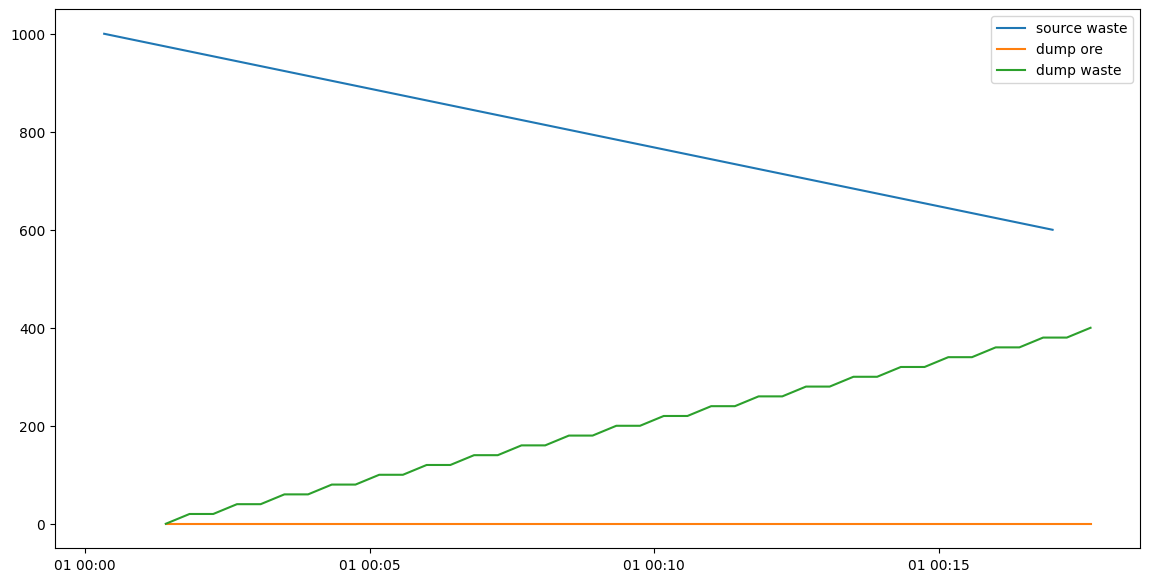

In [69]:
# Example usage:
res = run(total_trucks, 1000)
trucks = res['trucks']
activities_d_truck = res['activities_d_truck']
source = res['source']
dump = res['dump']

# Plotting
fig_gantt = plot.get_gantt_chart([*trucks.values()], id_map=[*activities_d_truck.values()])
fig_step = plot.get_step_chart([source, dump])

In [71]:

def run(total_trucks, total_waste):
    # Read the CSV file
    file_path = 'HaulageOperation_TruckDetails.csv'
    df = pd.read_csv(file_path)

    # Create an empty list to store information about each truck
    truck_list = []

    # Initialize a counter for overall truck numbering
    overall_truck_counter = 1

    # Iterate through rows and repeat based on the number of trucks
    for index, row in df.iterrows():
        # Convert 'Number of trucks' to integer
        num_trucks = int(row['Number of Trucks'])

        for truck_num in range(num_trucks):
            # Create a dictionary for each truck
            truck_info = {
                'ID': row['ID'],
                'Name of the trucks': f'truck{overall_truck_counter}',
                'Type': row['Type'],
                'Payload (Ton)': row['Payload (Ton)'],
                'Minimum Speed (Mile/Hour)': row['Minimum Speed (Mile/Hour)'],
                'Maximum Speed (Mile/Hour)': row['Maximum Speed (Mile/Hour)'],
                'Unloading Time (Minute)': row['Unloading Time (Minute)'],
                'Param 1': row['Param 1'],
                'Param 2': row['Param 2']
            }
            # Increment the overall truck counter
            overall_truck_counter += 1

            # Append the truck information to the list
            truck_list.append(truck_info)

    # Create a new data frame from the list
    df_result = pd.DataFrame(truck_list)

    # Calculate the total number of trucks as an integer
    total_trucks = int(df['Number of Trucks'].sum())

    # create a Site object based on desired mixin classes
    Site = type('Site',
                (core.Identifiable,
                 core.Log,
                 core.Locatable,
                 core.HasMultiContainer,
                 core.HasResource,), {})

    # create a TransportProcessingResource object based on desired mixin classes
    TransportProcessingResource = type(
        "TransportProcessingResource",
        (
            core.MultiContainerDependentMovable,
            core.HasResource,
            core.Processor,
            core.Identifiable,
            core.Log,
            opentnsim.core.ExtraMetadata
        ),
        {},
    )
    
    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    # prepare input data for source
    location_source = shapely.geometry.Point(4.062705498083785, 51.95909715255291)
    data_source = {"env": my_env,
                   "name": "source",
                   "geometry": location_source,
                   "initials": [
                       {"id": "waste", "level": total_waste, "capacity": total_waste},
                   ],
                   "nr_resources": 1
                   }
    source = Site(**data_source)

    # prepare input data for dump
    location_dump = shapely.geometry.Point(4.1795229742823, 52.11590591837503)
    data_dump = {"env": my_env,
                 "name": "dump",
                 "geometry": location_dump,
                 "initials": [
                     {"id": "ore", "level": 0, "capacity": 0},
                     {"id": "waste", "level": 0, "capacity": total_waste},
                 ],
                 }
    dump = Site(**data_dump)

    # create truck objects
    trucks = {}

    for i in range(1, total_trucks + 1):
        # Extract information from the truck list
        truck_info = df_result[df_result['Name of the trucks'] == f'truck{i}'].iloc[0]

        # Extract unloading time distribution parameters
        mean_unloading_time = truck_info['Param 1']
        std_dev_unloading_time = truck_info['Param 2']
        # Generate random unloading time from the specified distribution
        unloading_rate = np.random.normal(loc=mean_unloading_time, scale=std_dev_unloading_time)

        # Create an instance of TransportProcessingResource
        trucks[f"truck{i}"] = TransportProcessingResource(
            env=my_env,
            name=f"truck{i}",
            geometry=location_dump,
            initials=[
                {"id": "waste", "level": 0, "capacity": truck_info['Payload (Ton)']},
            ],
            loading_rate=1,
            unloading_rate=unloading_rate,
            compute_v=lambda x: 10 + 2 * x,
        )

    # Create activity objects
    activities_d_truck = {}

    for i in range(1, total_trucks + 1):
        requested_resources = {}

        d_subprocesses = [
            model.MoveActivity(
                env=my_env,
                name=f"driving_empty:" + trucks[f"truck{i}"].name,
                registry=registry,
                mover=trucks[f"truck{i}"],
                destination=source,
                duration=20,
            ),
            model.ShiftAmountActivity(
                env=my_env,
                name=f"loading:" + trucks[f"truck{i}"].name,
                registry=registry,
                processor=trucks[f"truck{i}"],
                origin=source,
                destination=trucks[f"truck{i}"],
                amount=20,
                duration=50,
                id_="waste",
                requested_resources=requested_resources,
            ),
            model.MoveActivity(
                env=my_env,
                name=f"driving_full:" + trucks[f"truck{i}"].name,
                registry=registry,
                mover=trucks[f"truck{i}"],
                destination=dump,
                duration=15,
            ),
            model.ShiftAmountActivity(
                env=my_env,
                name=f"unloading:" + trucks[f"truck{i}"].name,
                registry=registry,
                processor=trucks[f"truck{i}"],
                origin=trucks[f"truck{i}"],
                destination=dump,
                amount=20,
                duration=25,
                id_="waste",
                requested_resources=requested_resources,
            )
        ]

   # Create activity objects
    requested_resources = {}

    # Create subprocesses for all trucks
    d_subprocesses = [
        model.SequentialActivity(
            env=my_env,
            name=f"sequential_activity_d_truck{i}",
            registry=registry,
            sub_processes=[
                model.MoveActivity(
                    env=my_env,
                    name=f"driving_empty:" + trucks[f"truck{i}"].name,
                    registry=registry,
                    mover=trucks[f"truck{i}"],
                    destination=source,
                    duration=20,
                ),
                model.ShiftAmountActivity(
                    env=my_env,
                    name=f"loading:" + trucks[f"truck{i}"].name,
                    registry=registry,
                    processor=trucks[f"truck{i}"],
                    origin=source,
                    destination=trucks[f"truck{i}"],
                    amount=20,
                    duration=50,
                    id_="waste",
                    requested_resources=requested_resources,
                ),
                model.MoveActivity(
                    env=my_env,
                    name=f"driving_full:" + trucks[f"truck{i}"].name,
                    registry=registry,
                    mover=trucks[f"truck{i}"],
                    destination=dump,
                    duration=15,
                ),
                model.ShiftAmountActivity(
                    env=my_env,
                    name=f"unloading:" + trucks[f"truck{i}"].name,
                    registry=registry,
                    processor=trucks[f"truck{i}"],
                    origin=trucks[f"truck{i}"],
                    destination=dump,
                    amount=20,
                    duration=25,
                    id_="waste",
                    requested_resources=requested_resources,
                )
            ]
        ) for i in range(1, total_trucks + 1)
    ]

    # Create a WhileActivity to repeat all subprocesses until the condition event
    while_activity = model.WhileActivity(
        env=my_env,
        name="while_sequential_activities",
        registry=registry,
        sub_processes=d_subprocesses,
        condition_event=[{"type": "container", "concept": dump, "state": "full"}],
    )

    model.register_processes([while_activity])
    my_env.run()

    return {
        "trucks": trucks,
        "activities_d_truck": activities_d_truck,
        "source": source,
        "dump": dump,
    }

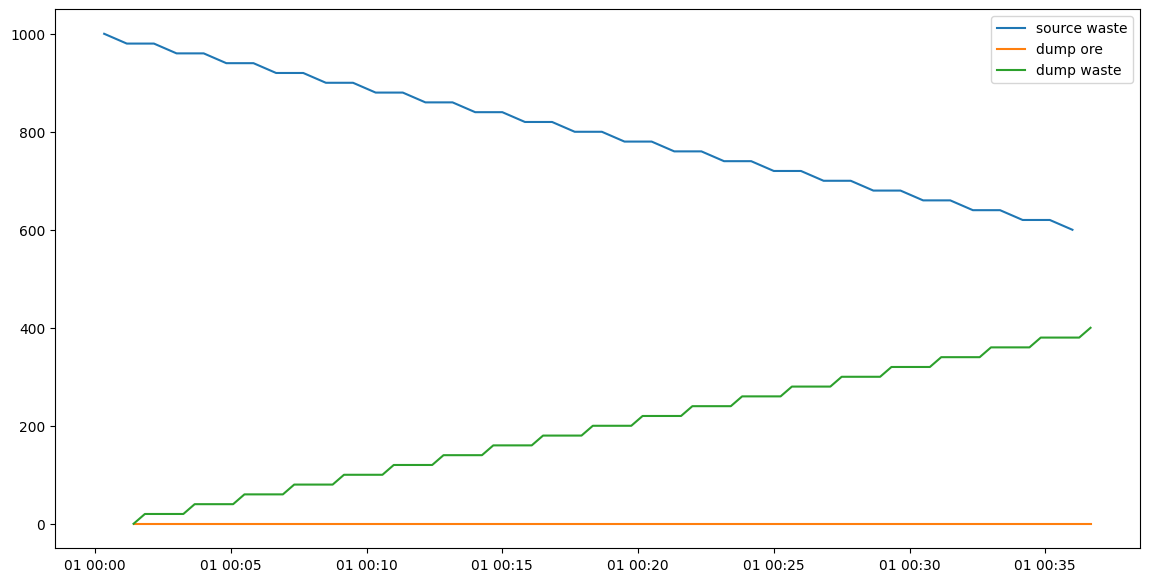

In [72]:
# Example usage:
res = run(total_trucks, 1000)
trucks = res['trucks']
activities_d_truck = res['activities_d_truck']
source = res['source']
dump = res['dump']

# Plotting
fig_gantt = plot.get_gantt_chart([*trucks.values()], id_map=[*activities_d_truck.values()])
fig_step = plot.get_step_chart([source, dump])

In [1]:
import networkx as nx  
import shapely.geometry
import pyproj


import datetime as dt
import time
import simpy
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
import opentnsim

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import folium

In [38]:

def run(total_waste):
    # Read the CSV file
    file_path = 'HaulageOperation_TruckDetails.csv'
    df = pd.read_csv(file_path)

    # Create an empty list to store information about each truck
    truck_list = []

    # Initialize a counter for overall truck numbering
    overall_truck_counter = 1

    # Iterate through rows and repeat based on the number of trucks
    for index, row in df.iterrows():
        # Convert 'Number of trucks' to integer
        num_trucks = int(row['Number of Trucks'])

        for truck_num in range(num_trucks):
            # Create a dictionary for each truck
            truck_info = {
                'ID': row['ID'],
                'Name of the trucks': f'truck{overall_truck_counter}',
                'Type': row['Type'],
                'Payload (Ton)': row['Payload (Ton)'],
                'Minimum Speed (Mile/Hour)': row['Minimum Speed (Mile/Hour)'],
                'Maximum Speed (Mile/Hour)': row['Maximum Speed (Mile/Hour)'],
                'Unloading Time (Minute)': row['Unloading Time (Minute)'],
                'Param 1': row['Param 1'],
                'Param 2': row['Param 2']
            }
            # Increment the overall truck counter
            overall_truck_counter += 1

            # Append the truck information to the list
            truck_list.append(truck_info)

    # Create a new data frame from the list
    df_result = pd.DataFrame(truck_list)

    # Calculate the total number of trucks as an integer
    total_trucks = int(df['Number of Trucks'].sum())

    # create a Site object based on desired mixin classes
    Site = type('Site',
                (core.Identifiable,
                 core.Log,
                 core.Locatable,
                 core.HasMultiContainer,
                 core.HasResource,), {})

    # create a TransportProcessingResource object based on desired mixin classes
    TransportProcessingResource = type(
        "TransportProcessingResource",
        (
            core.MultiContainerDependentMovable,
            core.HasResource,
            core.Processor,
            core.Identifiable,
            core.Log,
            opentnsim.core.ExtraMetadata
        ),
        {},
    )
    
    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    # prepare input data for source
    location_source01 = shapely.geometry.Point(4.062705498083785, 51.95909715255291)
    data_source01 = {"env": my_env,
                   "name": "source01",
                   "geometry": location_source01,
                   "initials": [
                       {"id": "waste", "level": total_waste, "capacity": total_waste},
                   ],
                   "nr_resources": 1
                   }
    source01 = Site(**data_source01)

    # prepare input data for dump
    location_dump01 = shapely.geometry.Point(4.1795229742823, 52.11590591837503)
    data_dump01 = {"env": my_env,
                 "name": "dump01",
                 "geometry": location_dump01,
                 "initials": [
                     {"id": "waste", "level": 0, "capacity": total_waste},
                 ],
                 }
    dump01 = Site(**data_dump01)

    # create truck objects
    trucks = {}

    for i in range(1, total_trucks + 1):
        # Extract information from the truck list
        truck_info = df_result[df_result['Name of the trucks'] == f'truck{i}'].iloc[0]

        # Extract unloading time distribution parameters
        mean_unloading_time = truck_info['Param 1']
        std_dev_unloading_time = truck_info['Param 2']
        # Generate random unloading time from the specified distribution
        unloading_rate = np.random.normal(loc=mean_unloading_time, scale=std_dev_unloading_time)

        # Create an instance of TransportProcessingResource
        trucks[f"truck{i}"] = TransportProcessingResource(
            env=my_env,
            name=f"truck{i}",
            geometry=location_dump01,
            initials=[
                {"id": "waste", "level": 0, "capacity": truck_info['Payload (Ton)']},
            ],
            loading_rate=1,
            unloading_rate=unloading_rate,
            compute_v=lambda x: 10 + 2 * x,
        )

   # Create activity objects
    activities_d_truck = {}

    for i in range(1, total_trucks + 1):
        requested_resources = {}
        truck = trucks[f"truck{i}"]
        d_subprocesses = [
            model.MoveActivity(
                env=my_env,
                name=f"driving_empty:" + trucks[f"truck{i}"].name,
                registry=registry,
                mover=trucks[f"truck{i}"],
                destination=source01,
                duration=20,
            ),
            model.ShiftAmountActivity(
                env=my_env,
                name=f"loading:" + trucks[f"truck{i}"].name,
                registry=registry,
                processor=trucks[f"truck{i}"],
                origin=source01,
                destination=trucks[f"truck{i}"],
                amount=20,
                duration=50,
                id_="waste",
                requested_resources=requested_resources,
            ),
            model.MoveActivity(
                env=my_env,
                name=f"driving_full:" + trucks[f"truck{i}"].name,
                registry=registry,
                mover=trucks[f"truck{i}"],
                destination=dump01,
                duration=15,
            ),
            model.ShiftAmountActivity(
                env=my_env,
                name=f"unloading:" + trucks[f"truck{i}"].name,
                registry=registry,
                processor=trucks[f"truck{i}"],
                origin=trucks[f"truck{i}"],
                destination=dump01,
                amount=20,
                duration=25,
                id_="waste",
                requested_resources=requested_resources,
            )
        ]
        activities_d_truck[f"activities_d_truck{i}"] = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_d_truck{i}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential_activity_d_truck{i}",
                registry=registry,
                sub_processes=d_subprocesses
            )],
            condition_event=[{"type": "container",
                              "concept": truck,
                              "state": "full",
                              "id_": "default_reservations"}
                             ]
        )

    model.register_processes([*activities_d_truck.values()])
    my_env.run()

    return {
        "trucks": trucks,
        "activities_d_truck": activities_d_truck,
        "source01": source01,
        "dump01": dump01,
        "total_trucks": total_trucks,  # Adding total_trucks to the returned dictionary
        "registry": registry,
    }

In [39]:
# Example usage:
res = run(600)
trucks = res['trucks']
activities_d_truck = res['activities_d_truck']
source01 = res['source01']
dump01 = res['dump01']
total_trucks = res['total_trucks']  # Extracting total_trucks
registry = res['registry']


In [40]:
truck1 = trucks['truck1']
pd.DataFrame(truck1.logbook)
pd.DataFrame(dump01.logbook)

,Timestamp,ActivityID,ActivityState,ObjectState,ActivityLabel
0,1970-01-01 00:01:25,9b1a5b41-5250-4b4a-ac13-8433546a6d14,START,"{'container level': {'waste': 0}, 'geometry': ...",{}
1,1970-01-01 00:01:50,9b1a5b41-5250-4b4a-ac13-8433546a6d14,STOP,"{'container level': {'waste': 20}, 'geometry':...",{}
2,1970-01-01 00:02:15,8ed2647f-e1c4-43b7-ac81-15c71b6d614d,START,"{'container level': {'waste': 20}, 'geometry':...",{}
3,1970-01-01 00:02:40,8ed2647f-e1c4-43b7-ac81-15c71b6d614d,STOP,"{'container level': {'waste': 40}, 'geometry':...",{}
4,1970-01-01 00:03:05,f56a4da4-6304-4e29-b2f9-21114386f830,START,"{'container level': {'waste': 40}, 'geometry':...",{}
5,1970-01-01 00:03:30,f56a4da4-6304-4e29-b2f9-21114386f830,STOP,"{'container level': {'waste': 60}, 'geometry':...",{}
6,1970-01-01 00:03:55,1a9d410a-efe6-4893-801a-2236d4d6e8bc,START,"{'container level': {'waste': 60}, 'geometry':...",{}
7,1970-01-01 00:04:20,1a9d410a-efe6-4893-801a-2236d4d6e8bc,STOP,"{'container level': {'waste': 80}, 'geometry':...",{}
8,1970-01-01 00:04:45,9a2c9cfe-9a05-4820-bf2c-fbf2518bf9ff,START,"{'container level': {'waste': 80}, 'geometry':...",{}
9,1970-01-01 00:05:10,9a2c9cfe-9a05-4820-bf2c-fbf2518bf9ff,STOP,"{'container level': {'waste': 100}, 'geometry'...",{}


In [41]:
# Plotting Gantt chart for a specific truck (e.g., "truck1")
specific_truck = "truck1"
specific_truck_activities = [activities_d_truck[f"activities_d_truck{i}"] for i in range(1, total_trucks + 1) if f"truck{i}" == specific_truck]

fig_gantt_specific_truck = plot.get_gantt_chart(specific_truck_activities, id_map=[*activities_d_truck.values()])

In [42]:
def expand(a, namespace):
    n = len(namespace)
    sa = []
    if a.name[0:n]==namespace:
        sa.append(a)
    if hasattr(a, "sub_processes"):
        for s in a.sub_processes:
            if s.name[0:n]==namespace:
                sa.append(s)
            sa+=expand(s,namespace)
    return sa

all_activities = []
for a in [*activities_d_truck]:
    all_activities+=expand(activities_d_truck[a],'load')
all_activities
fig = plot.get_gantt_chart(all_activities)


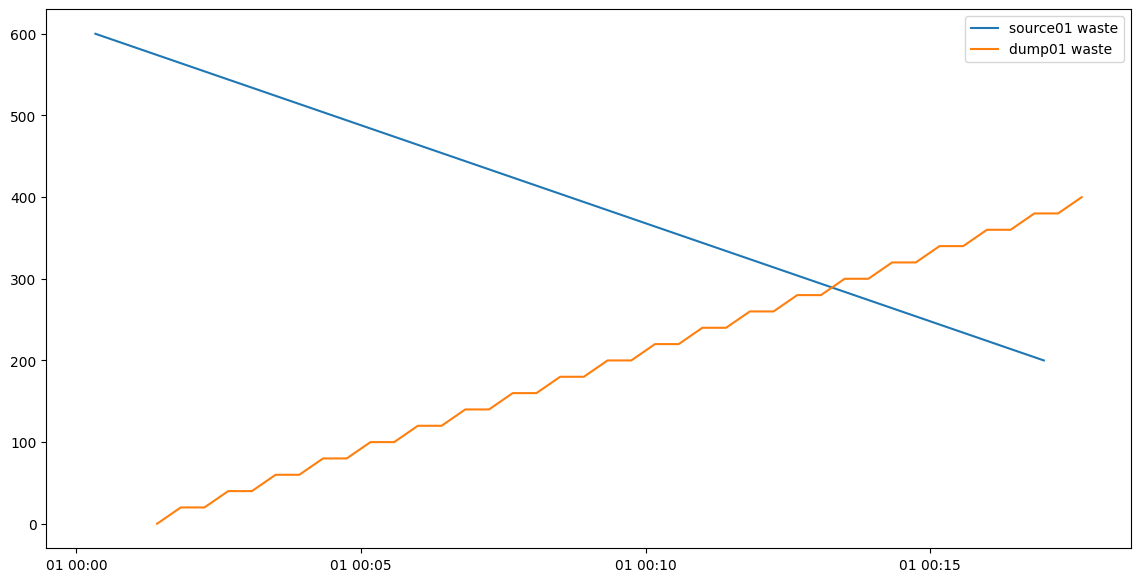

In [43]:
# Plotting
fig_gantt = plot.get_gantt_chart([*trucks.values()], id_map=[*activities_d_truck.values()])
fig_step = plot.get_step_chart([source01, dump01])

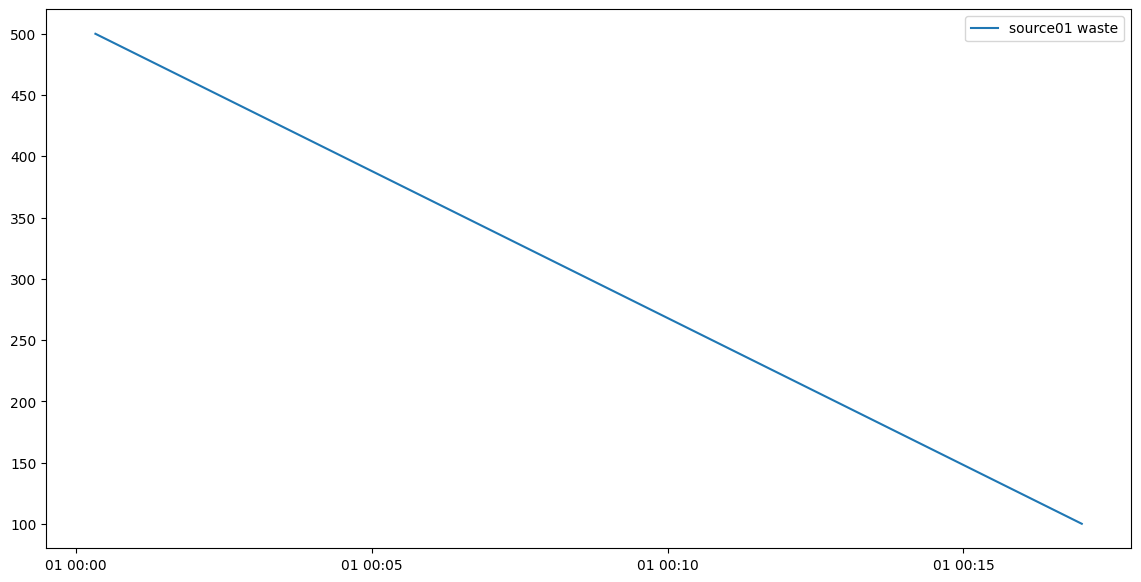

In [80]:
fig_step = plot.get_step_chart([source01])

In [76]:
display(plot.get_log_dataframe(source01,id_map=[*activities_d_truck.values()]))

,Activity,Timestamp,ActivityState,container level,geometry
0,loading:truck1,1970-01-01 00:00:20,START,{'waste': 1000},POINT (4.062705498083785 51.95909715255291)
1,loading:truck1,1970-01-01 00:01:10,STOP,{'waste': 980},POINT (4.062705498083785 51.95909715255291)
2,loading:truck2,1970-01-01 00:01:10,START,{'waste': 980},POINT (4.062705498083785 51.95909715255291)
3,loading:truck2,1970-01-01 00:02:00,STOP,{'waste': 960},POINT (4.062705498083785 51.95909715255291)
4,loading:truck3,1970-01-01 00:02:00,START,{'waste': 960},POINT (4.062705498083785 51.95909715255291)
5,loading:truck3,1970-01-01 00:02:50,STOP,{'waste': 940},POINT (4.062705498083785 51.95909715255291)
6,loading:truck4,1970-01-01 00:02:50,START,{'waste': 940},POINT (4.062705498083785 51.95909715255291)
7,loading:truck4,1970-01-01 00:03:40,STOP,{'waste': 920},POINT (4.062705498083785 51.95909715255291)
8,loading:truck5,1970-01-01 00:03:40,START,{'waste': 920},POINT (4.062705498083785 51.95909715255291)
9,loading:truck5,1970-01-01 00:04:30,STOP,{'waste': 900},POINT (4.062705498083785 51.95909715255291)


In [77]:
display(plot.get_log_dataframe(dump01,id_map=[*activities_d_truck.values()]))

,Activity,Timestamp,ActivityState,container level,geometry
0,unloading:truck1,1970-01-01 00:01:25,START,{'waste': 0},POINT (4.1795229742823 52.11590591837503)
1,unloading:truck1,1970-01-01 00:01:50,STOP,{'waste': 20},POINT (4.1795229742823 52.11590591837503)
2,unloading:truck2,1970-01-01 00:02:15,START,{'waste': 20},POINT (4.1795229742823 52.11590591837503)
3,unloading:truck2,1970-01-01 00:02:40,STOP,{'waste': 40},POINT (4.1795229742823 52.11590591837503)
4,unloading:truck3,1970-01-01 00:03:05,START,{'waste': 40},POINT (4.1795229742823 52.11590591837503)
5,unloading:truck3,1970-01-01 00:03:30,STOP,{'waste': 60},POINT (4.1795229742823 52.11590591837503)
6,unloading:truck4,1970-01-01 00:03:55,START,{'waste': 60},POINT (4.1795229742823 52.11590591837503)
7,unloading:truck4,1970-01-01 00:04:20,STOP,{'waste': 80},POINT (4.1795229742823 52.11590591837503)
8,unloading:truck5,1970-01-01 00:04:45,START,{'waste': 80},POINT (4.1795229742823 52.11590591837503)
9,unloading:truck5,1970-01-01 00:05:10,STOP,{'waste': 100},POINT (4.1795229742823 52.11590591837503)
